# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from IPython.display import display

import torch
from torch import nn
from torch.optim import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader, Dataset

# Classes & Functions

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset_dir, annotations_file, anno_y_col, anno_x_col, transform=None, target_transform=None):
        self.label_encoder = LabelEncoder()

        def preproc_index(annotations_file):
            df = pd.read_csv(annotations_file)
            df[anno_x_col] = df[anno_x_col].apply(lambda x : dataset_dir + x)
            return df

        self.img_labels = preproc_index(annotations_file)     #  encode_label(annotations_file)
        self.anno_x_col = anno_x_col
        self.anno_y_col = anno_y_col
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):        
        return len(self.img_labels)

    def show_img(self, idx):        
        img_path = self.img_labels.loc[idx, self.anno_x_col]        
        label = self.img_labels.loc[idx, self.anno_y_col]
        print(label, img_path)
        img = imread(img_path)
        plt.imshow(img, cmap="gray");
        plt.show();

    def __getitem__(self, idx):        
        img_path = self.img_labels.loc[idx, self.anno_x_col]
        image = read_image(img_path).type(torch.float)
        label = self.img_labels.loc[idx, self.anno_y_col]
        if self.transform:
            image = self.transform(image)        
        if self.target_transform:
            label = self.target_transform([label])[0]
        return image, label

# Load Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q -o gdrive/MyDrive/Dataset/fashion_mnist.zip -d ./data/

Mounted at /content/gdrive


In [4]:
# split index into train and test
df = pd.read_csv('data/fashion/index.csv')
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)
df_train.to_csv('data/fashion/index_train.csv')
df_test.to_csv('data/fashion/index_test.csv')
display(df_train['category'].value_counts())
display(df_test['category'].value_counts())

Coat          4800
Shirt         4800
T-shirt       4800
Sneaker       4800
Bag           4800
Trouser       4800
Ankle boot    4800
Pullover      4800
Dress         4800
Sandal        4800
Name: category, dtype: int64

T-shirt       1200
Pullover      1200
Trouser       1200
Dress         1200
Coat          1200
Sneaker       1200
Shirt         1200
Ankle boot    1200
Bag           1200
Sandal        1200
Name: category, dtype: int64

In [5]:
le = LabelEncoder()
le = le.fit(df_train['category'])
le.classes_

array(['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal',
       'Shirt', 'Sneaker', 'T-shirt', 'Trouser'], dtype=object)

In [6]:
le.transform(['Shirt'])

array([6])

48000 12000
Shirt ./data/fashion/img/fashion50398.png


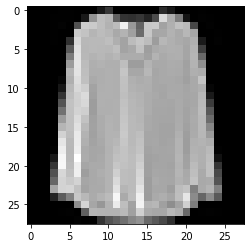

(tensor([[[  0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,  25.,  55.,
             0.,   0.,   0.,   0.,   0.,   0.,  43.,  24.,   0.,   0.,   0.,
             1.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   1.,   1.,   1.,   0.,  25., 147., 189., 181.,
            96.,  51.,  49.,  55.,  37.,  76., 217., 172., 125.,  20.,   0.,
             2.,   1.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   1.,   3.,   0.,  82., 206., 202., 190., 178.,
           188., 239., 152.,  99., 199., 201., 162., 176., 192., 185.,  71.,
             0.,   2.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   1.,   0.,   0., 202., 196., 181., 188., 183.,
           169., 179., 160., 107., 198., 166., 167., 178., 170., 183., 166.,
             0.,   0.,   1.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   1.,   0.,  48., 216., 184., 185., 185., 190.,
           175., 164., 188., 198., 188., 157., 183., 176., 171., 167., 175.,
            26.,   0.,   2.,   0.,   0

In [7]:
train_data = CustomImageDataset("./data/fashion/", "./data/fashion/index_train.csv", 'category', 'image', target_transform=le.transform)
test_data = CustomImageDataset("./data/fashion/", "./data/fashion/index_test.csv", 'category', 'image', target_transform=le.transform)

print(train_data.__len__(), test_data.__len__())

# show first data
train_data.show_img(0)    
train_data.__getitem__(0)

In [8]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(type(X[0][0][0][0]), y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

<class 'torch.Tensor'> tensor([5, 4, 5, 2, 1, 5, 0, 1, 2, 0, 2, 5, 3, 6, 0, 3, 4, 1, 5, 8, 9, 9, 2, 6,
        2, 0, 6, 8, 1, 7, 3, 7, 2, 8, 2, 1, 8, 7, 5, 5, 9, 4, 6, 9, 0, 8, 5, 2,
        5, 2, 3, 6, 7, 1, 9, 1, 8, 9, 9, 1, 0, 0, 4, 2])
Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


# Create Model

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


epochs = 5
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 10.263924  [    0/48000]
loss: 2.060580  [ 6400/48000]
loss: 2.213773  [12800/48000]
loss: 2.020173  [19200/48000]
loss: 2.006258  [25600/48000]
loss: 2.107241  [32000/48000]
loss: 2.055953  [38400/48000]
loss: 2.171502  [44800/48000]
Test Error: 
 Accuracy: 19.2%, Avg loss: 2.107322 

Epoch 2
-------------------------------
loss: 2.104666  [    0/48000]
loss: 1.984458  [ 6400/48000]
loss: 2.198002  [12800/48000]
loss: 1.987593  [19200/48000]
loss: 2.002504  [25600/48000]
loss: 2.084744  [32000/48000]
loss: 2.043664  [38400/48000]
loss: 2.144994  [44800/48000]
Test Error: 
 Accuracy: 19.4%, Avg loss: 2.101014 

Epoch 3
-------------------------------
loss: 2.098272  [    0/48000]
loss: 1.952780  [ 6400/48000]
loss: 2.201146  [12800/48000]
loss: 1.963513  [19200/48000]
loss: 2.005053  [25600/48000]
loss: 2.058241  [32000/48000]
loss: 2.021533  [38400/48000]
loss: 2.128213  [44800/48000]
Test Error: 
 Accuracy: 19.5%, Avg loss: 2.098552 

Epo

# Export & Import

In [12]:
torch.save(model.state_dict(), "model.pth")
pretrained_model = NeuralNetwork()
pretrained_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# Prediction

Predicted: "Sandal", Actual: "Sandal"
Sandal ./data/fashion/img/fashion37343.png


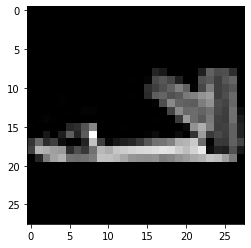

In [22]:
i = 0

model.eval()
X, y = test_data[i][0], test_data[i][1]
with torch.no_grad():
    pred = model(X)
    predicted, actual = le.classes_[pred[0].argmax(0)], le.classes_[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    test_data.show_img(i)    